In [32]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from pathlib import Path
import io
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

First we're loading the COVID-19 Data for Confirmed Cases in US from the public dataset drive link and storing it in a dataframe called "time_series_US_confirmed"

In [33]:
# Download a file based on its file ID.
# https://drive.google.com/file/d/1XsRqaT1TUUOs4zOI6Lr6tPTZ3WGj0Dav/view?usp=sharing
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz


# https://drive.google.com/file/d/1LJ_KeAGF3upj7x7wfXADsLcAmqZ1tlvT/view?usp=share_link

file_id = '1LJ_KeAGF3upj7x7wfXADsLcAmqZ1tlvT'

file_obj = drive.CreateFile({'id': file_id})
content_string = file_obj.GetContentString()

time_series_US_confirmed = pd.read_csv(io.StringIO(content_string))
time_series_US_confirmed



,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,3/19/22,3/20/22,3/21/22,3/22/22,3/23/22,3/24/22,3/25/22,3/26/22,3/27/22,3/28/22
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,15582,15582,15586,15593,15596,15607,15611,15611,15611,15616
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,55327,55327,55353,55355,55358,55365,55373,55373,55373,55385
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,5467,5467,5471,5475,5475,5478,5478,5478,5478,5655
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,6411,6411,6411,6411,6413,6415,6415,6415,6415,6416
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,14889,14889,14891,14892,14890,14894,14896,14896,14896,14898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3337,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,...,9863,9863,9863,9887,9887,9887,9905,9905,9905,9905
3338,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,...,5635,5635,5635,5633,5633,5633,5632,5632,5632,5632
3339,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3340,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,...,2347,2347,2347,2349,2349,2349,2354,2354,2354,2354


In [34]:
# Dropping columns that are not required for the state-level analysis
columns_to_drop = ['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat', 'Long_']
US_confirmed_cases = time_series_US_confirmed.drop(columns=columns_to_drop)

# Grouping by 'Province_State' and summing the cases for each state
US_confirmed_cases_grouped = US_confirmed_cases.groupby('Province_State').sum()

# Display the first few rows of the grouped dataframe
US_confirmed_cases_grouped.head()


<ipython-input-34-cc2e23576e7f>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  US_confirmed_cases_grouped = US_confirmed_cases.groupby('Province_State').sum()


,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/19/22,3/20/22,3/21/22,3/22/22,3/23/22,3/24/22,3/25/22,3/26/22,3/27/22,3/28/22
Province_State,,,,,,,,,,,,,,,,,,,,,
Alabama,0,0,0,0,0,0,0,0,0,0,...,1291186,1291186,1291561,1291761,1291946,1292344,1292508,1292508,1292508,1294532
Alaska,0,0,0,0,0,0,0,0,0,0,...,244887,244887,245251,245251,245832,245832,245832,245832,245832,246385
American Samoa,0,0,0,0,0,0,0,0,0,0,...,1066,1066,1397,1556,1626,1993,2262,2262,2262,3278
Arizona,0,0,0,0,1,1,1,1,1,1,...,1992471,1992471,1992471,1992471,1992471,1997037,1997037,1997037,1997037,1997037
Arkansas,0,0,0,0,0,0,0,0,0,0,...,830020,830310,831091,831698,831947,832205,832394,832515,832553,832574


The **US_confirmed_cases** dataframe now contains the cumulative confirmed COVID-19 cases in the United States, grouped by state. Each column represents a different date, starting from January 22, 2020, and ending on March 28, 2022.

Next, I'll perform some analysis on this data, including:

1. Identifying the states with the highest total confirmed cases.
2. Visualizing the growth of cases over time for selected states.
3. Analyzing the overall trends in the data, such as periods of rapid increase or decrease in case numbers.

Let's begin with identifying the states with the highest total confirmed cases as of the most recent date in the dataset.

In [35]:
# # Summing all the column values per state to get the total confirmed cases for each state
total_cases_per_state = US_confirmed_cases_grouped.sum(axis=1)

# Identifying the top 10 states with the highest total confirmed cases
top_10_states_total = total_cases_per_state.sort_values(ascending=False).head(10)

# Displaying the top 10 states with their total confirmed cases
top_10_states_total

Province_State
California        2404448104
Texas             1905943069
Florida           1598434800
New York          1313394664
Illinois           857974935
Pennsylvania       735693218
Georgia            725467651
Ohio               708234012
North Carolina     659333129
New Jersey         611668149
dtype: int64

Next, I will visualize the growth of cases over time for each of these top 10 states. Let's proceed with creating the time series plot for this purpose.

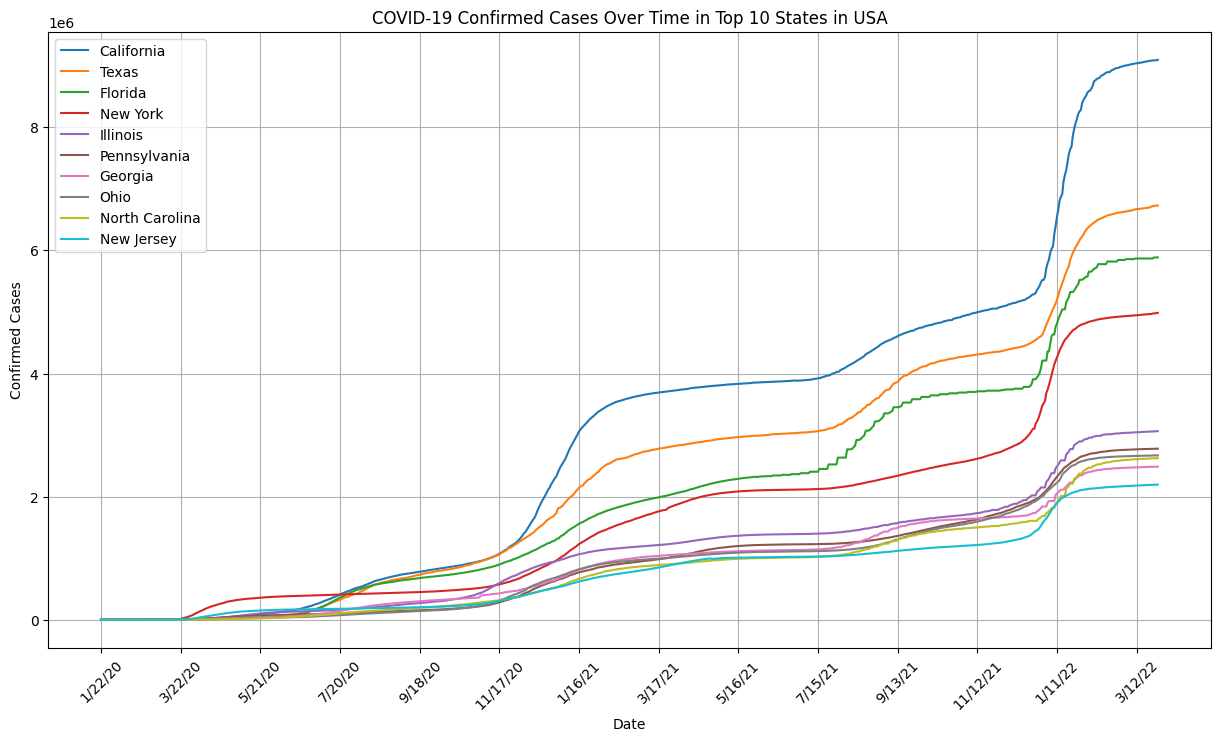

In [36]:
# Selecting data for the top 10 states with the highest total confirmed cases
top_10_states_total_data = US_confirmed_cases_grouped.loc[top_10_states_total.index]

# Plotting the time series data for the top 10 states
plt.figure(figsize=(15, 8))
for state in top_10_states_total_data.index:
    plt.plot(top_10_states_total_data.columns, top_10_states_total_data.loc[state], label=state)

plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title('COVID-19 Confirmed Cases Over Time in Top 10 States in USA')
plt.xticks(top_10_states_total_data.columns[::60], rotation=45)  # Show every 2 Months for data clarity
plt.legend()
plt.grid(True)
plt.show()


The plot above illustrates the growth of COVID-19 confirmed cases over time for the top 10 states with the highest total number of cases, based on the sum of all cases reported on each date in the dataset. Each line in the plot represents the cumulative case count for one of these states.

Key observations from this visualization:

Rapid Growth Phases: You can observe distinct periods where the case counts increased rapidly, indicative of various pandemic waves.
Differences in Scale and Timing: The trajectories of these states vary both in the scale of the outbreak and the timing of their peaks.
Largest Burden in California and Texas: California and Texas, in particular, show a significantly higher burden of cases compared to other states in the top 10.

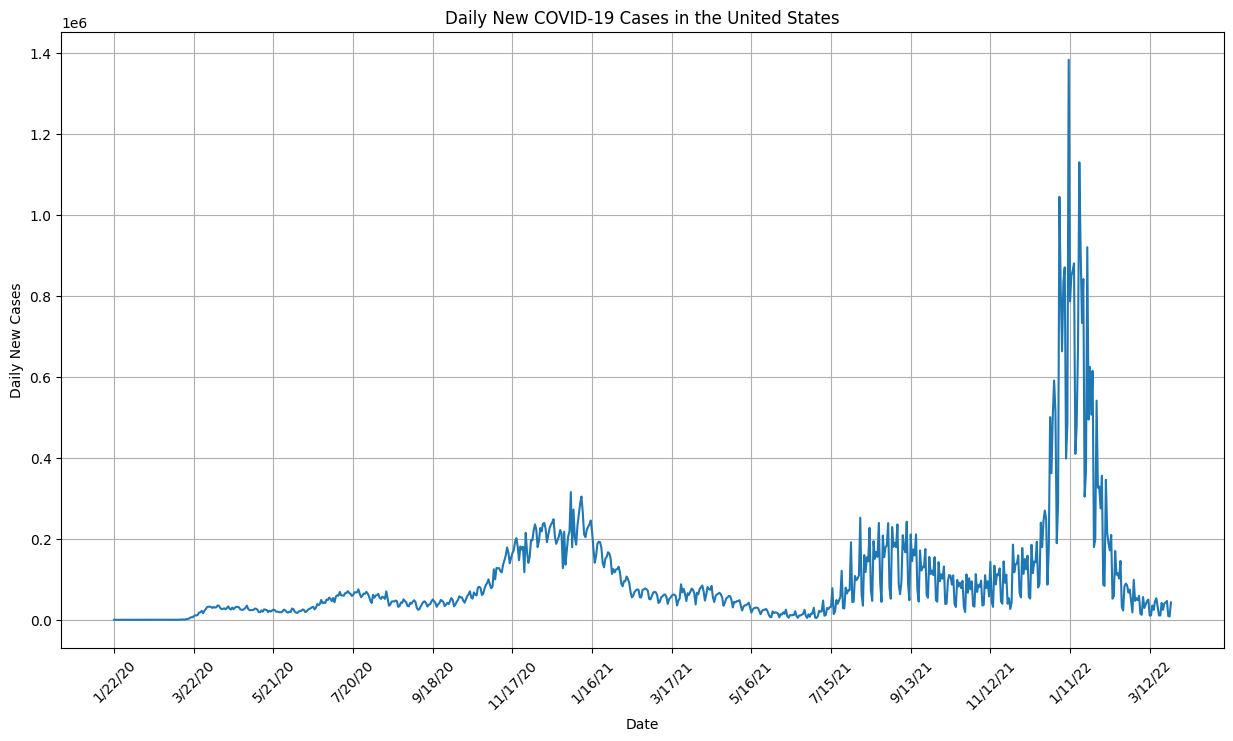

In [37]:
# Calculating the daily new cases for the entire United States
daily_new_cases_US = US_confirmed_cases_grouped.diff(axis=1).sum(axis=0)

# Dropping the first column as it will be NaN after differencing
daily_new_cases_US = daily_new_cases_US.dropna()

# Plotting the daily new cases
plt.figure(figsize=(15, 8))
plt.plot(daily_new_cases_US.index, daily_new_cases_US.values)
plt.xlabel('Date')
plt.ylabel('Daily New Cases')
plt.title('Daily New COVID-19 Cases in the United States')
plt.xticks(daily_new_cases_US.index[::60], rotation=45)  # Show every 60th date for clarity
plt.grid(True)
plt.show()


The plot above illustrates the daily new COVID-19 cases across the United States from January 22, 2020, to March 28, 2022. The key insights from this visualization are:

Initial Outbreak: The initial outbreak phase is visible, with a steep rise in daily new cases.
Subsequent Waves: There are several peaks, each representing a wave of the pandemic. These peaks likely correspond to the emergence of new variants, seasonal changes, and varying public health measures.
Fluctuations: There are notable fluctuations in daily new cases, reflecting the dynamic nature of the pandemic's spread and the impact of interventions like lockdowns and vaccination campaigns.

Now let's follow the same procedure for the US deaths chart.

In [38]:
#https://drive.google.com/file/d/16zizKFO2yyzH1g6QpBVrXZRzmC5QiGlT/view?usp=share_link

file_id2 = '16zizKFO2yyzH1g6QpBVrXZRzmC5QiGlT'

file_obj2 = drive.CreateFile({'id': file_id2})
content_string2 = file_obj2.GetContentString()

time_series_US_deaths = pd.read_csv(io.StringIO(content_string2))
time_series_US_deaths.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,3/19/22,3/20/22,3/21/22,3/22/22,3/23/22,3/24/22,3/25/22,3/26/22,3/27/22,3/28/22
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,210,210,210,210,210,209,209,209,209,210
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,669,669,672,673,673,673,674,674,674,675
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,94,94,94,97,97,97,97,97,97,97
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,100,100,100,101,101,101,101,101,101,101
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,230,230,230,230,230,230,233,233,233,235


In [39]:
# Dropping columns that are not required for the state-level analysis of deaths
columns_to_drop_deaths = ['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat', 'Long_', 'Population']
df_deaths_dropped = time_series_US_deaths.drop(columns=columns_to_drop_deaths)

# Grouping by 'Province_State' and summing the deaths for each state
time_series_US_deaths = df_deaths_dropped.groupby('Province_State').sum()

# Summing all the column values per state to get the total deaths for each state
total_deaths_per_state = time_series_US_deaths.sum(axis=1)

# Identifying the top 10 states with the highest total deaths
top_10_states_deaths_total = total_deaths_per_state.sort_values(ascending=False).head(10)
top_2_states_deaths = top_10_states_deaths_total.head(2)
top_10_states_deaths_total

<ipython-input-39-fea4d06f4388>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_series_US_deaths = df_deaths_dropped.groupby('Province_State').sum()


Province_State
New York        33202448
California      32552479
Texas           30133469
Florida         23842982
New Jersey      16118969
Pennsylvania    15615839
Illinois        14395151
Georgia         12424485
Michigan        12194554
Ohio            12191250
dtype: int64

The top 10 states with the highest total number of COVID-19 deaths, when summing across all available dates in the dataset, are:

1. New York: 33,202,448 deaths
2.  California: 32,552,479 deaths
3.  Texas: 30,133,469 deaths
4.  Florida: 23,842,982 deaths
5. New Jersey: 16,118,969 deaths
6. Pennsylvania: 15,615,839 deaths
7. Illinois: 14,395,151 deaths
8. Georgia: 12,424,485 deaths
9. Michigan: 12,194,554 deaths
10. Ohio: 12,191,250 deaths


Next, I will visualize the growth of deaths over time for each of these top 10 states. Let's proceed with creating the time series plot for this purpose.

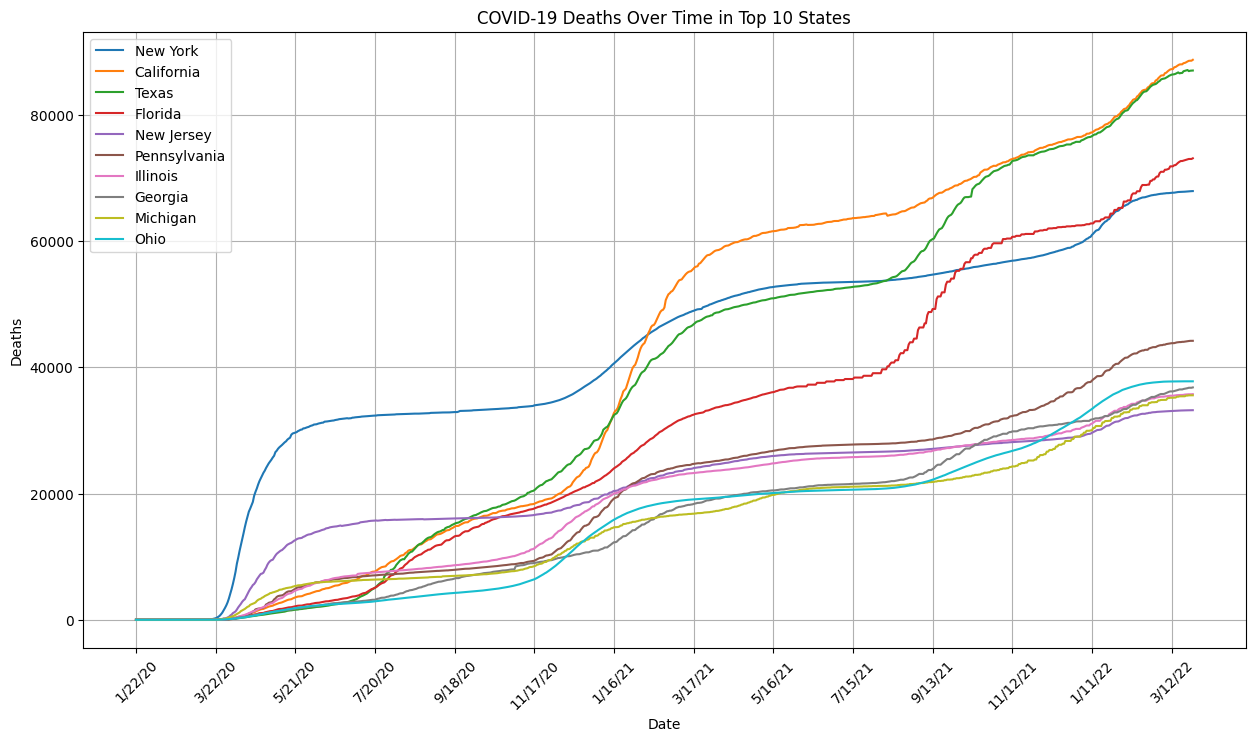

In [40]:
# Selecting data for the top 10 states with the highest total deaths
top_10_states_deaths_data = time_series_US_deaths.loc[top_10_states_deaths_total.index]

# Plotting the time series data for the top 10 states
plt.figure(figsize=(15, 8))
for state in top_10_states_deaths_data.index:
    plt.plot(top_10_states_deaths_data.columns, top_10_states_deaths_data.loc[state], label=state)

plt.xlabel('Date')
plt.ylabel('Deaths')
plt.title('COVID-19 Deaths Over Time in Top 10 States')
plt.xticks(top_10_states_deaths_data.columns[::60], rotation=45)  # Show every 60th date for clarity
plt.legend()
plt.grid(True)
plt.show()


The plot above shows the progression of COVID-19 related deaths over time for the top 10 states with the highest total number of deaths, based on the sum of all reported deaths on each date in the dataset. Each line in the plot represents the cumulative death count for one of these states.

Key observations include:

1. Significant Variability: The states exhibit significant variability in the total number of deaths and the rate at which these deaths occurred over time.
2. Major Peaks: The plot highlights major peaks in deaths, which likely correspond to different waves of the pandemic.
3. New York and California: These states, in particular, show a higher burden of deaths compared to other states in the top 10.

Let us now focus on one state, California, since it has the highest number of cases and deaths over time.

Let us perform some time-series modelling and analysis for the same In order to do that, we are
1. Preprocessing the Data: Extracting the time series data appropriately for California from the dataset.

2. Ridge Regression Setup: We'll set up a Ridge Regression model. This involves creating a series of time-based features to use as predictors.

3. Training the Model: We'll train the model on the available data.

4. Prediction: We'll predict the number of cases for the last 6 months and compare the prediction with the actual dataset to analyze how good our model is.

RMSE: 1736812.1410718348


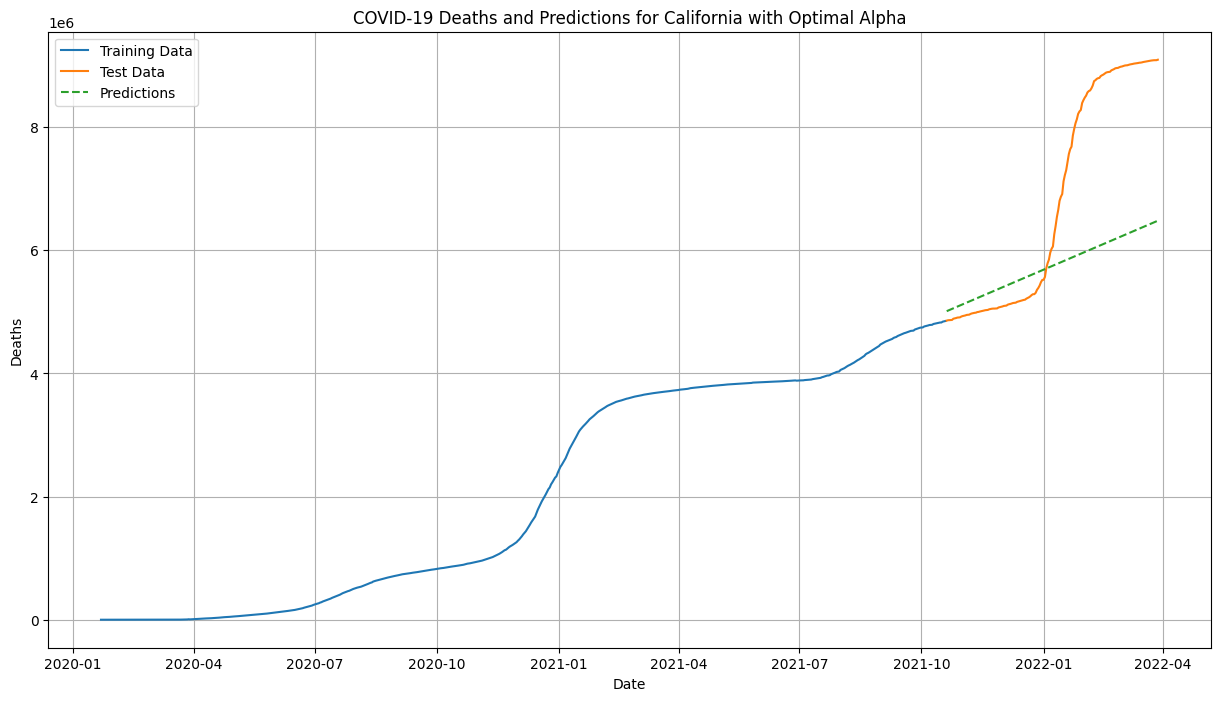

In [63]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from datetime import timedelta

# Extracting data for California
california_data = US_confirmed_cases_grouped.loc['California']

# Converting dates to numerical values for regression
california_data.index = pd.to_datetime(california_data.index)
days_since_start = (california_data.index - california_data.index.min()).days
X = days_since_start.values.reshape(-1, 1)
y = california_data.values

# Splitting the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Defining a range of alpha values to try
alpha_values = np.logspace(-10, 10, 100)

# Fitting a Ridge Regression model with cross-validation
ridge_model_cv = RidgeCV(alphas=alpha_values, store_cv_values=True)
ridge_model_cv.fit(X_train, y_train)

# Predictions on the test set
y_pred = ridge_model_cv.predict(X_test)

# Calculating the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

# Plotting the results including the test set
plt.figure(figsize=(15, 8))
plt.plot(california_data.index[:train_size], y_train, label='Training Data')
plt.plot(california_data.index[train_size:], y_test, label='Test Data')
plt.plot(california_data.index[train_size:], y_pred, label='Predictions', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.title('COVID-19 Confirmed Cases and Predictions for California with Optimal Alpha')
plt.legend()
plt.grid(True)
plt.show()

RMSE: 7649.455982366825


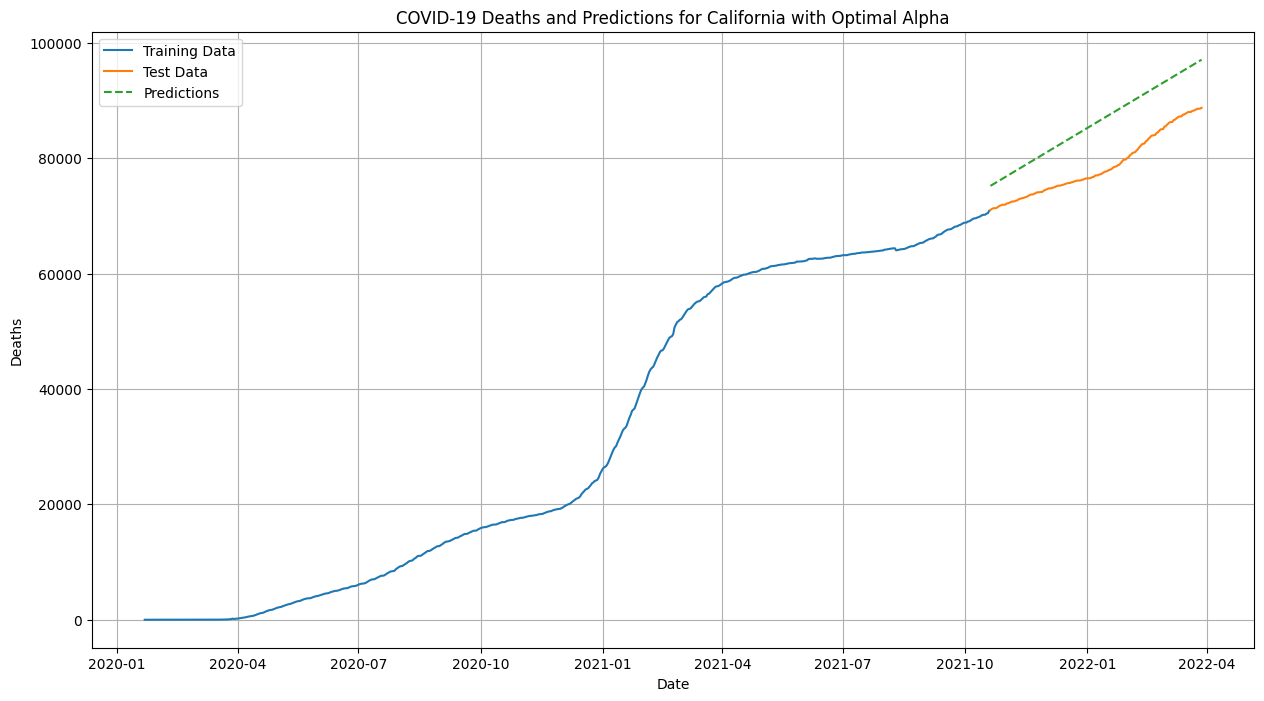

In [61]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from datetime import timedelta

# Extracting data for California
california_data = time_series_US_deaths.loc['California']

# Converting dates to numerical values for regression
california_data.index = pd.to_datetime(california_data.index)
days_since_start = (california_data.index - california_data.index.min()).days
X = days_since_start.values.reshape(-1, 1)
y = california_data.values

# Splitting the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Defining a range of alpha values to try
alpha_values = np.logspace(-10, 10, 100)

# Fitting a Ridge Regression model with cross-validation
ridge_model_cv = RidgeCV(alphas=alpha_values, store_cv_values=True)
ridge_model_cv.fit(X_train, y_train)

# Predictions on the test set
y_pred = ridge_model_cv.predict(X_test)

# Calculating the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

# Plotting the results including the test set
plt.figure(figsize=(15, 8))
plt.plot(california_data.index[:train_size], y_train, label='Training Data')
plt.plot(california_data.index[train_size:], y_test, label='Test Data')
plt.plot(california_data.index[train_size:], y_pred, label='Predictions', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.title('COVID-19 Deaths and Predictions for California with Optimal Alpha')
plt.legend()
plt.grid(True)
plt.show()

From the two prediction graphs:
1. COVID-19 Confirmed Cases and Predictions for California with Optimal Alpha
2. COVID-19 Deaths and Predictions for California with Optimal Alpha

We can conclude that the time series prediction worked better for the dataset of confirmed deaths. This is because during the last six months of both the datasets, there was a sharp increase in the number of confirmed cases in California versus a very steady rise of confirmed deaths.

Since our regression model works best for linear data sets, the RMSE for the second graph is much lower than the first graph.

This is synchronous for what happened in real life. In the last covid wave, the state of California was much better equipped to handle the situation, leading to less number of deaths desptie a sharp rise in number of cases.

Finally, we are trying to predict the next six months of COVID-19 deaths for California.

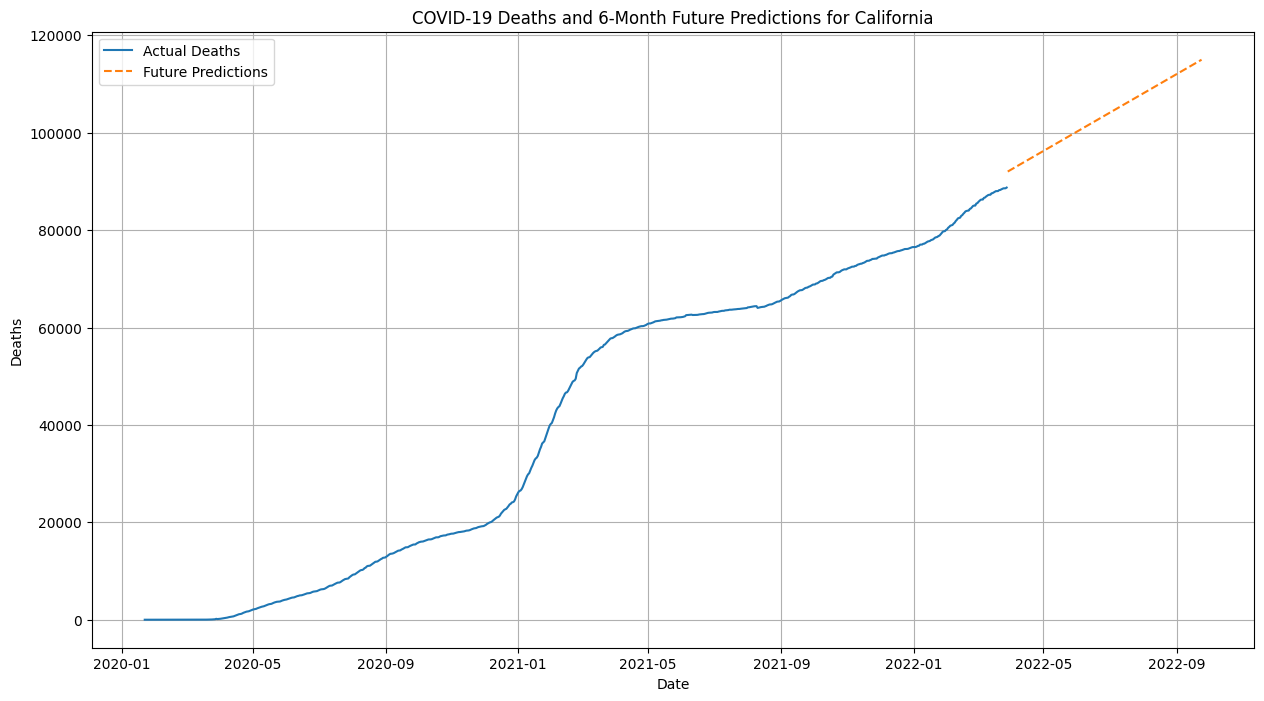

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from datetime import timedelta

# Assuming 'time_series_US_deaths' is already loaded and processed as per your previous code

# Extracting data for California
california_data = time_series_US_deaths.loc['California']

# Converting dates to numerical values for regression
california_data.index = pd.to_datetime(california_data.index)
days_since_start = (california_data.index - california_data.index.min()).days
X = days_since_start.values.reshape(-1, 1)
y = california_data.values

# Fitting a Ridge Regression model with cross-validation
alpha_values = np.logspace(-10, 10, 100)
ridge_model_cv = RidgeCV(alphas=alpha_values, store_cv_values=True)
ridge_model_cv.fit(X, y)

# Creating future time points for the next 6 months
last_day = X[-1, 0]
future_days = np.arange(last_day + 1, last_day + 1 + 6 * 30)  # approximating a month as 30 days
X_future = future_days.reshape(-1, 1)

# Predicting future values
future_predictions = ridge_model_cv.predict(X_future)

# Plotting the results
plt.figure(figsize=(15, 8))
plt.plot(california_data.index, california_data, label='Actual Deaths')
plt.plot(california_data.index.min() + pd.to_timedelta(X_future.flatten(), 'D'), future_predictions, label='Future Predictions', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.title('COVID-19 Deaths and 6-Month Future Predictions for California')
plt.legend()
plt.grid(True)
plt.show()
